In [1]:
import os
import numpy as np
import random
import pandas as pd
import sys 

from PIL import Image
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
import matplotlib.pyplot as plt
import kagglehub

from constants import excel_filename, dataset_name
from modelos.RegresionLogistica import regresion_logistica
from modelos.CNN import cnn1, cnn2
from modelos.KNN import knn
from modelos.ArbolDeDecision import arbol_decision

## guardar datos en excel ##
def save_to_excel(datos):
    # Si el archivo ya existe, se leerá y se agregará nueva información
    metodo =  datos.pop("Método")
    if os.path.exists(excel_filename):
        results = pd.read_excel(excel_filename, index_col=0)
        df = pd.DataFrame(datos, index=metodo)
        results = pd.concat([results, df], ignore_index=False)
        results.to_excel(excel_filename)
    else:
        results = pd.DataFrame(datos)
        results.index = metodo
        results.to_excel(excel_filename)

#función para hacer la gráfica después de evaluar el rendimiento
def plot_rendimiento(exactitud, sensibilidad, precision, matriz_confusion, clases, fpr_micro, tpr_micro, roc_auc_micro, fpr, tpr, roc_auc):
    # Imprimir métricas de evaluación
    print("Exactitud    : %.2f %%" % exactitud)
    print("Sensibilidad : %.2f %%" % sensibilidad)
    print("Precisión    : %.2f %%" % precision)

    #matriz de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=clases)
    disp.plot()
    disp.figure_.suptitle("Matriz de confusión")
    disp.figure_.set_dpi(100)
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.show()

    #roc y auc
    plt.figure()
    plt.plot(fpr_micro, tpr_micro, color='red', lw=2, label='Curva ROC micro-average (AUC = %0.3f)' % roc_auc_micro)
    plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend(loc="lower right")
    plt.show()

    # Curvas ROC por clase
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'blue', 'violet', 'gold', 'orange', 'pink', 'tan', 'purple', 'lime', 'red']
    for i in range(len(clases)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=1, label='ROC clase %i (area = %0.3f)' % (i, roc_auc[i]))

    plt.plot(fpr_micro, tpr_micro, color='red', lw=2, linestyle=':', label='Curva ROC micro-average (AUC = %0.3f)' % roc_auc_micro)
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC por clase')
    plt.legend(loc="lower right")
    plt.show()

## evaluar rendimiento ##
def evaluar_rendimiento(model, X_test, y_test, nombre_metodo, pca):
    # Aplanar las imágenes de prueba
    X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Aplanar a 2D: [n_samples, n_features]
    
    # Normalizar los datos de prueba (debe coincidir con la normalización de X_train)
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test_flat)
    
    # Aplicar PCA al conjunto de prueba (debe ser la misma transformación que en el entrenamiento)
    if pca is not None:
        X_test_pca = pca.transform(X_test_scaled)  # Aquí usamos el PCA entrenado para transformar X_test
    else:
        X_test_pca = model.pca.transform(X_test_scaled)  # Aquí usamos el PCA entrenado para transformar X_test

    # Hacer predicciones
    y_pred = model.predict(X_test_pca)

    # Métricas de rendimiento
    precision = 100 * accuracy_score(y_test, y_pred)
    sensibility = 100 * recall_score(y_test, y_pred, average='macro')
    precision_score_value = 100 * precision_score(y_test, y_pred, average='macro')

    # Informe de clasificación
    print("Informe de evaluación del clasificador sobre el conjunto de test:\n", classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

    # ROC y AUC
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.arange(0, n_classes, 1))
    y_score = model.predict_proba(X_test_pca)

    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # ROC por clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Aquí iría la función para guardar en Excel (asegúrate de que 'Excel_data' y 'save_to_excel' están bien implementadas)
    datos = {
        "Método": [nombre_metodo],
        "Exactitud": [100 * accuracy_score(y_test, y_pred)],
        "Precisión": [100 * precision_score(y_test, y_pred, average='macro')],
        "Matriz de confusión": [cm],
        "fpr_micro": [fpr_micro],
        "tpr_micro": [tpr_micro],
        "roc_auc_micro": [roc_auc_micro],
        "fpr": [fpr],
        "tpr": [tpr],
        "roc_auc": [roc_auc]
    }
    save_to_excel(datos)
    # plot rendimiento
    plot_rendimiento(
        precision,
        sensibility,
        precision_score_value,
        cm,
        model.classes_,
        fpr_micro,
        tpr_micro,
        roc_auc_micro,
        fpr,
        tpr,
        roc_auc
    )


## cargar imágenes ##
def cargar_imagenes(image_path, target_size=(256, 256), channel_mode="rgb"):

    img_list = []
    labels = []
    classes = os.listdir(image_path)

    for folder in classes:
        folder_path = os.path.join(image_path, folder)

        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    img = Image.open(os.path.join(folder_path, filename)).convert("RGB")
                    img_array = np.array(img)

                    # Redimensionar
                    img_resized = resize(img_array, target_size, anti_aliasing=True)

                    # Modos de canal
                    if channel_mode == "grayscale":
                        img_resized = rgb2gray(img_resized)  # Convertir a escala de grises
                    elif channel_mode == "r":  # Canal rojo
                        img_resized = img_resized[:, :, 0]
                    elif channel_mode == "g":  # Canal verde
                        img_resized = img_resized[:, :, 1]
                    elif channel_mode == "b":  # Canal azul
                        img_resized = img_resized[:, :, 2]
                    elif channel_mode == "rgb":
                        img_resized = (img_resized * 255).astype(np.uint8)  # Restaurar valores de píxeles

                    img_resized = img_resized / 255.0  # Normalizar
                    img_list.append(img_resized)
                    labels.append(folder)  # Guardar etiqueta

    return np.array(img_list), np.array(labels)        


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download(dataset_name)

# cargar train y test
X_train_rgb, y_train = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), channel_mode="rgb")
X_test_rgb, y_test = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), channel_mode="rgb")
#X_train_gray, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), channel_mode="grayscale")
#X_test_gray, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), channel_mode="grayscale")
#X_train_rgb_64, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), target_size=(64, 64))
#X_test_rgb_64, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), target_size=(64, 64))

# Codificar etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

epochs = 100
batch_size = 100
history = []

In [3]:
X_train_flattened = X_train_rgb.reshape(X_train_rgb.shape[0], -1)  # Convierte a 2D (n_samples, n_features)
X_test_flattened = X_test_rgb.reshape(X_test_rgb.shape[0], -1)      # Hace lo mismo para el test set

In [4]:
# regresion logistica
from sklearn.linear_model import LogisticRegression

modelLR = LogisticRegression(penalty=None, solver = 'lbfgs', max_iter=10000)


In [5]:
import sklearn

sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

In [7]:
from sklearn.model_selection import cross_validate

#cross validation
CV = 5
scoring = ['precision_macro', 'recall_macro', 'precision_micro', 'recall_micro', 'f1_macro', 'accuracy', 'roc_auc']
scoresLR = cross_validate(modelLR, X_train_flattened, y_train_encoded, cv=CV, scoring=scoring)


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Usuario\AppData\Local\Programs\Py

In [8]:
scoresLR

{'fit_time': array([285.45449805, 250.56476378, 220.91799974, 367.83896399,
        242.47340703]),
 'score_time': array([0.68959761, 0.58199167, 1.05319333, 0.93041348, 0.67825603]),
 'test_precision_macro': array([0.360911  , 0.34869617, 0.32552323, 0.36698258, 0.37940236]),
 'test_recall_macro': array([0.3612659 , 0.34811868, 0.3235971 , 0.35968507, 0.36655325]),
 'test_precision_micro': array([0.37429379, 0.34887006, 0.32627119, 0.37429379, 0.37711864]),
 'test_recall_micro': array([0.37429379, 0.34887006, 0.32627119, 0.37429379, 0.37711864]),
 'test_f1_macro': array([0.35879968, 0.34641024, 0.32419283, 0.35815078, 0.36552693]),
 'test_accuracy': array([0.37429379, 0.34887006, 0.32627119, 0.37429379, 0.37711864]),
 'test_roc_auc': array([nan, nan, nan, nan, nan])}

In [ ]:
## funciones para validación cruzada ##
def save_excel_cv(scores, nombre_metodo):
    datos = {
        'precision_macro': [np.mean(scoresLR['test_precision_macro'])],
        'recall_macro': [np.mean(scoresLR['test_recall_macro'])],
        'precision_micro': [np.mean(scoresLR['test_precision_micro'])],
        'recall_micro': [np.mean(scoresLR['test_recall_micro'])], 
        'f1_macro': [np.mean(scoresLR['test_f1_macro'])], 
        'accuracy': [np.mean(scoresLR['test_accuracy'])], 
        'roc_auc': [np.mean(scoresLR['test_roc_auc'])]
    }
    if os.path.exists(excel_filename):
        results = pd.read_excel(excel_filename, index_col=0)
        df = pd.DataFrame(datos, index=[nombre_metodo])
        results = pd.concat([results, df], ignore_index=False)
        results.to_excel(excel_filename)
    else:
        results = pd.DataFrame(datos)
        results.index = [nombre_metodo]
        results.to_excel(excel_filename)

In [ ]:
save_excel_cv(scoresLR, "Regresión Logística RGB")


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def knn(X_train_rgb, y_train_encoded, X_test_rgb, y_test_encoded):
    X_train_flattened = X_train_rgb.reshape(X_train_rgb.shape[0], -1)
    X_test_flattened = X_test_rgb.reshape(X_test_rgb.shape[0], -1)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flattened)
    X_test_scaled = scaler.transform(X_test_flattened)
    
    pca = PCA(n_components=50)  # You can adjust n_components as needed
    X_train_pca = pca.fit_transform(X_train_scaled)
    #X_test_pca = pca.transform(X_test_scaled)
    
    knn_model = KNeighborsClassifier(n_neighbors=3)
    knn_model.fit(X_train_pca, y_train_encoded)
    
    # Return both the trained KNN model and PCA model as a tuple
    return knn_model, pca


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

def knn_with_gridsearch(X_train_rgb, y_train_encoded, X_test_rgb, y_test_encoded):
    # Aplanar las imágenes para convertirlas en una matriz 2D
    X_train_flattened = X_train_rgb.reshape(X_train_rgb.shape[0], -1)
    X_test_flattened = X_test_rgb.reshape(X_test_rgb.shape[0], -1)

    # Escalar las características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flattened)
    X_test_scaled = scaler.transform(X_test_flattened)

    # Definir el espacio de búsqueda de los hiperparámetros
    param_grid = {
        'pca__n_components': [30, 50],  # Número de componentes principales
        'knn__n_neighbors': [3, 7]  # Número de vecinos para el clasificador KNN
    }

    # Crear un pipeline para aplicar PCA seguido de KNN
    pipeline = Pipeline([
        ('pca', PCA()),  # PCA en el pipeline
        ('knn', KNeighborsClassifier())  # KNN en el pipeline
    ])

    # Usar GridSearchCV para buscar los mejores hiperparámetros
    grid_search = GridSearchCV(pipeline, param_grid, cv=5)  # Validación cruzada
    grid_search.fit(X_train_scaled, y_train_encoded)

    # Imprimir los mejores parámetros encontrados
    print(f"Mejores parámetros: {grid_search.best_params_}")

    # Obtener el mejor modelo entrenado con los mejores hiperparámetros
    best_model = grid_search.best_estimator_

    # Extraer la mejor instancia de PCA y KNN
    best_pca = best_model.named_steps['pca']
    best_knn = best_model.named_steps['knn']
    results = pd.DataFrame(grid_search.cv_results_)[['param_pca__n_components', 'param_knn__n_neighbors', 'mean_test_score']]
    print(results.sort_values(by='mean_test_score', ascending=False))  # Ordenar de mejor a peor

    # Devolver el modelo KNN y la instancia de PCA como una tupla (igual que la función knn)
    return best_knn, best_pca


In [14]:
modelKNN, pcaKNN = knn_with_gridsearch(X_train_rgb, y_train_encoded, X_test_rgb, y_test_encoded)

Mejores parámetros: {'knn__n_neighbors': 7, 'pca__n_components': 30}
   param_pca__n_components  param_knn__n_neighbors  mean_test_score
2                       30                       7         0.434746
3                       50                       7         0.429379
1                       50                       3         0.416384
0                       30                       3         0.414689


Informe de evaluación del clasificador sobre el conjunto de test:
               precision    recall  f1-score   support

           0       0.36      0.40      0.38        10
           1       0.18      0.20      0.19        10
           2       0.50      0.10      0.17        10
           3       0.40      0.40      0.40        10
           4       0.38      0.60      0.46        10

    accuracy                           0.34        50
   macro avg       0.36      0.34      0.32        50
weighted avg       0.36      0.34      0.32        50

Exactitud    : 34.00 %
Sensibilidad : 34.00 %
Precisión    : 36.41 %


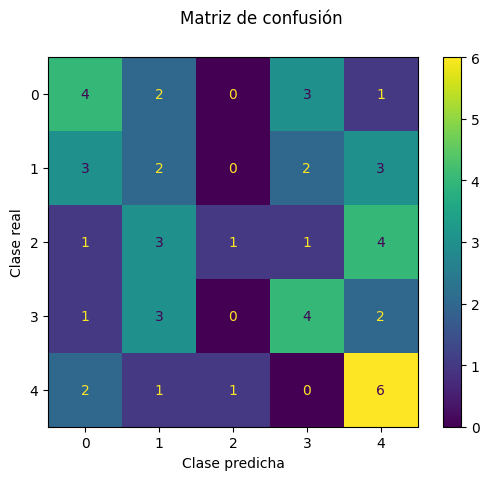

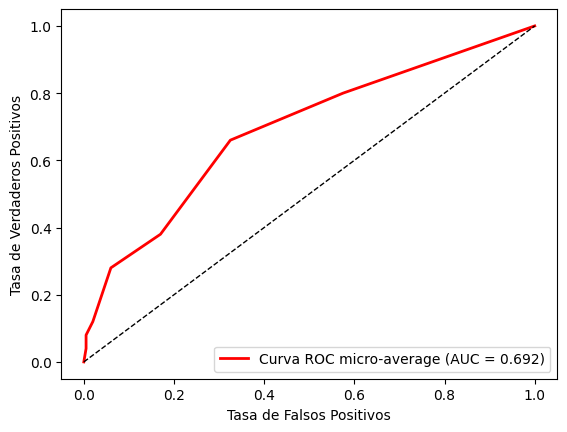

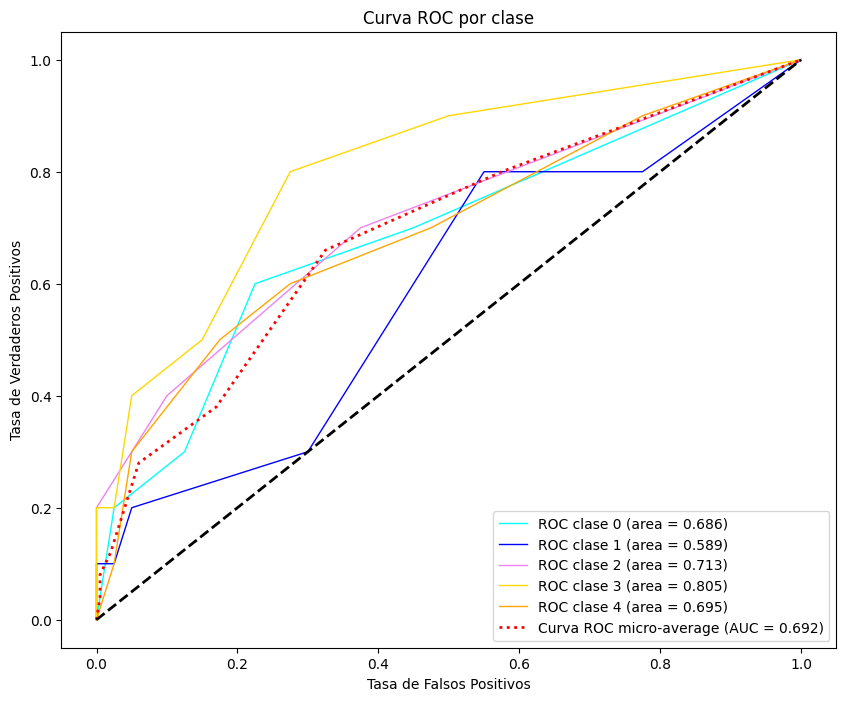

In [15]:
evaluar_rendimiento(modelKNN, X_test_rgb, y_test_encoded, "KNN", pcaKNN)

In [16]:
#modelKNN, pcaKNN = knn(X_train_rgb, y_train_encoded, X_test_rgb, y_test_encoded)


In [17]:
#evaluar_rendimiento(modelKNN, X_test_rgb, y_test_encoded, "KNN", pcaKNN)


In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

def build_mobilenetv2_model(input_shape=(256, 256, 3), num_classes=5, dense_units=1024, dropout_rate=0.5, learning_rate=0.001):
    # Cargar MobileNetV2 preentrenado sin la capa superior
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Congelar las capas convolucionales para no entrenarlas inicialmente
    for layer in base_model.layers:
        layer.trainable = False

    # Construir el modelo con la capa GlobalAveragePooling2D y las capas densas
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Reducción de la dimensionalidad
    x = Dense(dense_units, activation='relu')(x)  # Capa densa con hiperparámetro ajustable
    x = Dropout(dropout_rate)(x)  # Capa de Dropout para regularización
    predictions = Dense(num_classes, activation='softmax')(x)  # Capa de salida con softmax

    # Crear el modelo final
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def train_mobilenetv2_model(X_train, y_train, X_test, y_test, input_shape=(256, 256, 3), num_classes=5, epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.5, learning_rate=0.001):

    model = build_mobilenetv2_model(input_shape=input_shape, num_classes=num_classes, dense_units=dense_units, dropout_rate=dropout_rate, learning_rate=learning_rate)
    
    # Configurar EarlyStopping para evitar sobreajuste
    earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entrenar el modelo
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[earlystop_callback],
        verbose=1
    )
        # Evaluar el modelo en los datos de prueba
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Precisión en los datos de prueba: {accuracy:.2f}")
    
    # Visualización del historial de entrenamiento
    plt.figure(figsize=(12, 6))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.title('Precisión durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.show()
    
    return model

In [21]:
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_train_encoded))  # Asegurar que tenemos el número correcto de clases
y_train_onehot = to_categorical(y_train_encoded, num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_1416\2108597354.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 84s 706ms/step - accuracy: 0.7184 - loss: 0.8107 - val_accuracy: 0.7200 - val_loss: 0.8294
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 77s 691ms/step - accuracy: 0.8910 - loss: 0.3069 - val_accuracy: 0.7800 - val_loss: 0.6672
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 76s 685ms/step - accuracy: 0.9230 - loss: 0.2125 - val_accuracy: 0.8200 - val_loss: 0.7553
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 77s 691ms/step - accuracy: 0.9348 - loss: 0.1836 - val_accuracy: 0.7800 - val_loss: 0.8298
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 76s 682ms/step - accuracy: 0.9496 - loss: 0.1346 - val_accuracy: 0.8000 - val_loss: 0.9453
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 76s 687ms/step - accuracy: 0.9621 - loss: 0.1187 - val_accuracy: 0.7600 - val_loss: 1.0354
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 76s 682ms/step - accuracy: 0.9607 - loss: 0.0969 - val_accuracy: 0.7800 - val_loss: 0.9442
Precisión en los datos de prueba: 0.78


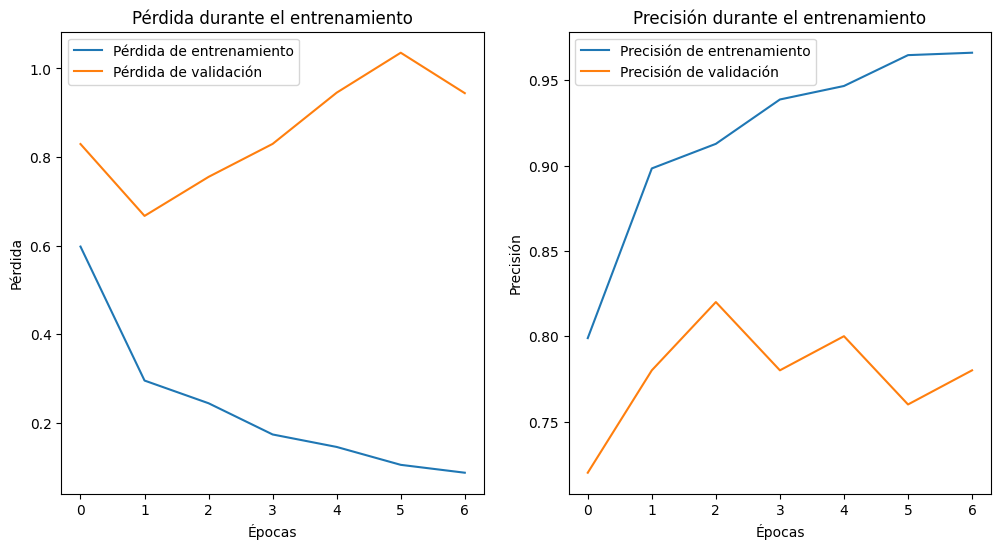

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.5337 - loss: 1.3564 - val_accuracy: 0.5400 - val_loss: 0.9839
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7967 - loss: 0.5801 - val_accuracy: 0.6200 - val_loss: 1.0934
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8533 - loss: 0.4094 - val_accuracy: 0.6200 - val_loss: 1.2608
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9010 - loss: 0.3087 - val_accuracy: 0.6600 - val_loss: 1.2622
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9345 - loss: 0.2061 - val_accuracy: 0.6600 - val_loss: 1.4641
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9455 - loss: 0.1758 - val_accuracy: 0.6800 - val_loss: 1.6032
Precisión en los datos de prueba: 0.54


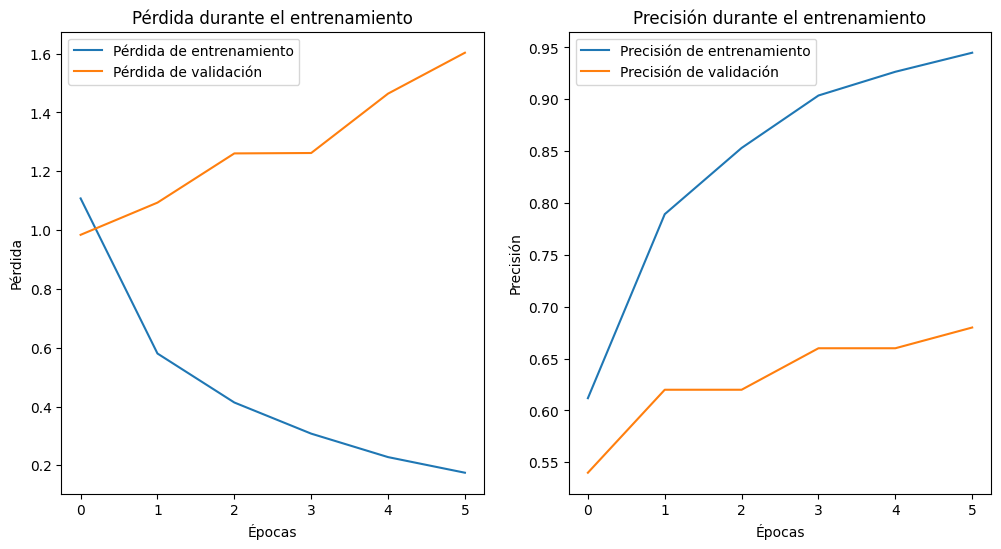

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.3724 - loss: 1.6449 - val_accuracy: 0.6200 - val_loss: 1.0551
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.6352 - loss: 0.9330 - val_accuracy: 0.6400 - val_loss: 1.0211
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7265 - loss: 0.7358 - val_accuracy: 0.6400 - val_loss: 0.9998
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.7763 - loss: 0.6187 - val_accuracy: 0.6800 - val_loss: 0.9837
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.8199 - loss: 0.5240 - val_accuracy: 0.6800 - val_loss: 0.9917
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8286 - loss: 0.4807 - val_accuracy: 0.6600 - val_loss: 1.0121
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.8503 - loss: 0.4147 - val_accuracy: 0.6600 - val_loss: 0.9793
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8882 - loss: 0.3611 - val_acc

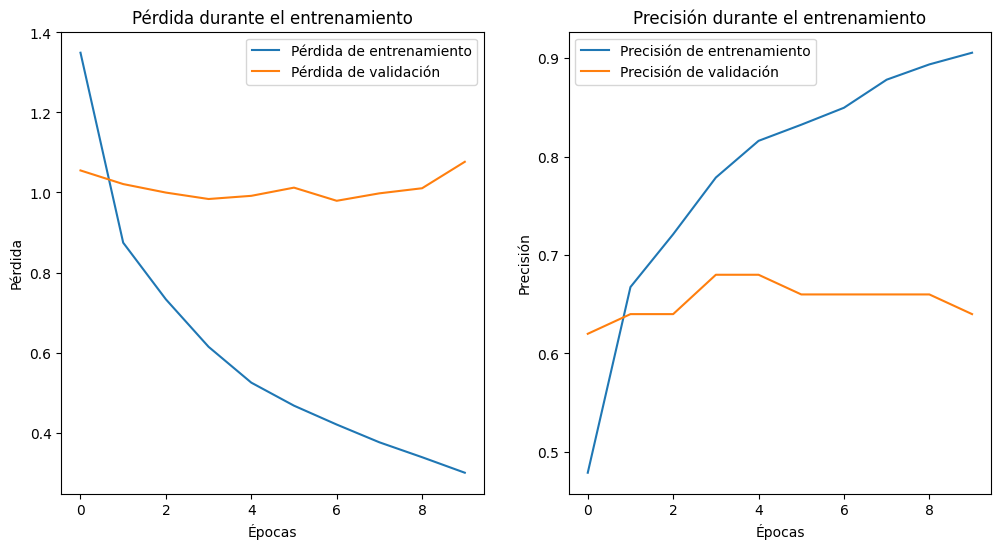

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.5766 - loss: 1.2293 - val_accuracy: 0.6800 - val_loss: 1.0185
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.8386 - loss: 0.4681 - val_accuracy: 0.5800 - val_loss: 1.2502
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9078 - loss: 0.2941 - val_accuracy: 0.6800 - val_loss: 1.1591
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9529 - loss: 0.1781 - val_accuracy: 0.6400 - val_loss: 1.5866
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9736 - loss: 0.1089 - val_accuracy: 0.6600 - val_loss: 1.4913
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9762 - loss: 0.0817 - val_accuracy: 0.6600 - val_loss: 1.4647
Precisión en los datos de prueba: 0.68


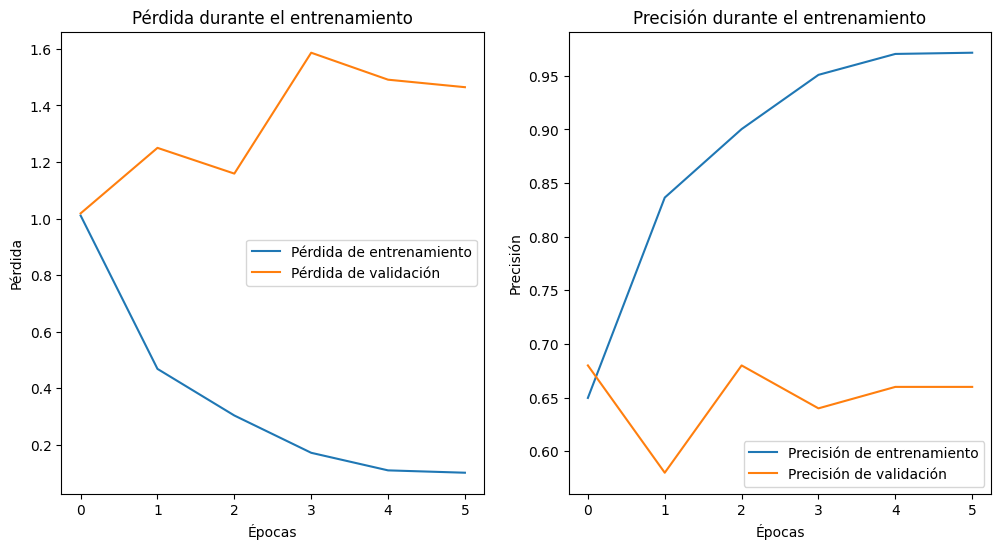

In [26]:
# Llamada a la función de entrenamiento
model_1 = train_mobilenetv2_model(X_train_rgb, y_train_onehot, X_test_rgb, y_test_onehot, epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.5, learning_rate=0.001)
model_2 = train_mobilenetv2_model(X_train_rgb_64, y_train_onehot, X_test_rgb_64, y_test_onehot, input_shape=(64, 64, 3), epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.5, learning_rate=0.001)
model_3 = train_mobilenetv2_model(X_train_rgb_64, y_train_onehot, X_test_rgb_64, y_test_onehot, input_shape=(64, 64, 3),epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.5, learning_rate=0.0001)
model_4 = train_mobilenetv2_model(X_train_rgb_64, y_train_onehot, X_test_rgb_64, y_test_onehot, input_shape=(64, 64, 3),epochs=10, batch_size=32, dense_units=1024, dropout_rate=0.3, learning_rate=0.001)

In [27]:
from skimage.feature import hog
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report

def extract_hog_features(images):
    hog_features = []
    for img in images:
        feature = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(feature)
    return np.array(hog_features)

def ann_hog(X_train_hog, y_train, X_test_hog, y_test, num_classes):
    # Convertir las etiquetas a one-hot encoding
    y_train_onehot = to_categorical(y_train, num_classes)
    y_test_onehot = to_categorical(y_test, num_classes)

    # Crear el modelo ANN
    ann_model = Sequential([
        Dense(512, activation='relu', input_dim=X_train_hog.shape[1]),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # num_classes = cantidad de clases
    ])

    # Compilar el modelo
    ann_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo ANN
    ann_model.fit(X_train_hog, y_train_onehot, epochs=5, batch_size=32, validation_data=(X_test_hog, y_test_onehot))

    # Obtener predicciones
    y_pred_ann = ann_model.predict(X_test_hog)
    y_pred_ann_classes = np.argmax(y_pred_ann, axis=1)

    # Calcular precisión
    accuracy_ann = accuracy_score(y_test, y_pred_ann_classes)
    print(f"Precisión ANN con HOG: {accuracy_ann:.2f}")

    # Generar reporte de clasificación
    print("\nReporte de ANN con HOG:")
    print(classification_report(y_test, y_pred_ann_classes))

    return ann_model

In [31]:
def main_hog(X_train, X_test, y_train, y_test, num_classes):
    # Extraer características HOG
    X_train_hog = extract_hog_features(X_train)
    X_test_hog = extract_hog_features(X_test)

    # Entrenar y evaluar ANN con características HOG
    print("Entrenando y evaluando ANN con características HOG...")
    ann_model = ann_hog(X_train_hog, y_train, X_test_hog, y_test, num_classes)

    # Entrenar y evaluar SVM con características HOG
    print("\nEntrenando y evaluando SVM con características HOG...")
    svm_model = svm_hog(X_train_hog, y_train, X_test_hog, y_test)

    return ann_model, svm_model

def extract_hog_features(images):
    hog_features = []
    for img in images:
        feature = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(feature)
    return np.array(hog_features)

from skimage.feature import hog
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report

def ann_hog(X_train_hog, y_train, X_test_hog, y_test, num_classes):
    # Convertir las etiquetas a one-hot encoding
    y_train_onehot = to_categorical(y_train, num_classes)
    y_test_onehot = to_categorical(y_test, num_classes)

    # Crear el modelo ANN
    ann_model = Sequential([
        Dense(512, activation='relu', input_dim=X_train_hog.shape[1]),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # num_classes = cantidad de clases
    ])

    # Compilar el modelo
    ann_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo ANN
    ann_model.fit(X_train_hog, y_train_onehot, epochs=5, batch_size=32, validation_data=(X_test_hog, y_test_onehot))

    # Obtener predicciones
    y_pred_ann = ann_model.predict(X_test_hog)
    y_pred_ann_classes = np.argmax(y_pred_ann, axis=1)

    # Calcular precisión
    accuracy_ann = accuracy_score(y_test, y_pred_ann_classes)
    print(f"Precisión ANN con HOG: {accuracy_ann:.2f}")

    # Generar reporte de clasificación
    print("\nReporte de ANN con HOG:")
    print(classification_report(y_test, y_pred_ann_classes))

    return ann_model

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

def svm_hog(X_train_hog, y_train, X_test_hog, y_test):
    # Crear y entrenar el clasificador SVM
    svm_model = SVC(kernel="linear", random_state=42)
    svm_model.fit(X_train_hog, y_train)

    # Hacer predicciones en el conjunto de prueba
    y_pred_svm = svm_model.predict(X_test_hog)

    # Evaluar precisión
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    print(f"Precisión SVM con HOG: {accuracy_svm:.2f}")

    # Generar reporte de clasificación
    print("\nReporte de SVM con HOG:")
    print(classification_report(y_test, y_pred_svm))

    return svm_model

In [33]:
num_classes = len(np.unique(y_train))  # Suponiendo que y_train contiene las etiquetas
main_hog(X_train_gray, X_test_gray, y_train_encoded, y_test_encoded, num_classes)


Entrenando y evaluando ANN con características HOG...
Epoch 1/5


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.2795 - loss: 1.9631 - val_accuracy: 0.2800 - val_loss: 1.4997
Epoch 2/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3558 - loss: 1.4486 - val_accuracy: 0.3600 - val_loss: 1.4602
Epoch 3/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.3607 - loss: 1.4614 - val_accuracy: 0.3600 - val_loss: 1.4861
Epoch 4/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.3957 - loss: 1.4025 - val_accuracy: 0.3000 - val_loss: 1.4993
Epoch 5/5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.3928 - loss: 1.3958 - val_accuracy: 0.3600 - val_loss: 1.4649
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Precisión ANN con HOG: 0.36

Reporte de ANN con HOG:
              precision    recall  f1-score   support

           0       0.33      0.30      0.32        10
           1       0.50      0.40      0.44        10
           2       0.67      0.40      0.50        10
           3       0.08      0.10      0.09        10
        

(<Sequential name=sequential, built=True>,
 SVC(kernel='linear', random_state=42))